In [3]:
!tar -xf resistors.tar.xz

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white'
})


In [53]:
def get_points(img):
    # Convert to grayscale and process to obtain a binary edge image.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
    th = cv2.threshold(gray_blur, 25, 255, cv2.THRESH_BINARY)[1]

    # Find pixel locations where the thresholded image is 255.
    ys, xs = np.where(th == 255)
    points = np.column_stack((xs, ys))   # each point as (x, y)

    # Center the data and compute the covariance matrix.
    mean = points.mean(axis=0)  # shape (2,)
    pts_centered = points - mean
    cov = np.cov(pts_centered, rowvar=False)

    # Compute the eigenvectors and select the one with the largest eigenvalue.
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    principal_vec = eigenvectors[:, np.argmax(eigenvalues)]
    
    # Define the line endpoints along the principal direction.
    length = max(img.shape)  # large enough to span the image
    x0, y0 = mean
    dx, dy = principal_vec  # principal direction components

    # Endpoints of the line (floating-point)
    x1, y1 = x0 - dx * length, y0 - dy * length
    x2, y2 = x0 + dx * length, y0 + dy * length

    # Convert to integer pixel coordinates and clip to image boundaries.
    h, w = img.shape[:2]
    r1, c1 = int(round(y1)), int(round(x1))
    r2, c2 = int(round(y2)), int(round(x2))
    r1, c1 = np.clip([r1, c1], [0, 0], [h-1, w-1])
    r2, c2 = np.clip([r2, c2], [0, 0], [h-1, w-1])
    
    # Use linear interpolation to get sample points along the line.
    num = int(np.hypot(r2 - r1, c2 - c1))
    sample_cols = np.linspace(c1, c2, num)
    sample_rows = np.linspace(r1, r2, num)

    # Preprocess image: convert BGR to RGB, then apply CLAHE to L channel.
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rgb_img = cv2.GaussianBlur(rgb_img, (5, 5), 0)  # optional additional blur

    # Convert the color image to LAB, apply CLAHE to L and convert back.
    lab_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab_img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2, a, b))
    out_color = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)

    # Compute the perpendicular direction. For (dx, dy), a perpendicular vector is (-dy, dx).
    perp_vec = np.array([-dy, dx])  # already normalized if principal_vec is normalized

    # Prepare a list to collect the mean color at each sample point.
    averaged_samples = []

    # For each sample point along the principal axis, sample pixels along the perpendicular.
    # We'll gather 3 points on either side (+ the center = 7 total).
    num_side = 3  # 3 on each side
    for col, row in zip(sample_cols, sample_rows):
        # Initialize a list to collect the neighboring pixel colors.
        neighborhood = []
        # For offsets from -3 to +3 along the perpendicular:
        for offset in range(-num_side, num_side+1):
            # Compute the offset; note: (x, y) corresponds to (col, row)
            x_offset = col + offset * perp_vec[0]
            y_offset = row + offset * perp_vec[1]
            # Round and clip to valid pixel indices.
            x_idx = int(round(x_offset))
            y_idx = int(round(y_offset))
            x_idx = np.clip(x_idx, 0, w-1)
            y_idx = np.clip(y_idx, 0, h-1)
            # Sample the color at this location.
            neighborhood.append(out_color[y_idx, x_idx].astype(np.float32))
        # Compute the mean color for the neighborhood.
        mean_color = np.mean(neighborhood, axis=0)
        averaged_samples.append(mean_color.astype(np.uint8))

    # Convert to an array; shape (num_samples, 3)
    sampled_colors = np.array(averaged_samples)

    return sampled_colors

In [76]:
def plot_color_strip(sampled_colors):
    """
    Plot the RGB channel intensities along the strip (x-axis: sample number, y-axis: intensity)
    and display on top a rectangular color profile of the strip.
    """
    # Create an x-axis for the sample index.
    x = np.arange(len(sampled_colors))
    # Separate channels assuming sampled_colors is an (N,3) array in RGB format.
    r = sampled_colors[:, 0]
    g = sampled_colors[:, 1]
    b = sampled_colors[:, 2]
    
    # Compute the Euclidean color difference between adjacent samples.
    # This gives an array of length (N-1). We then compute the x positions at the midpoints.
    diffs = np.sqrt(np.diff(r)**2 + np.diff(g)**2 + np.diff(b)**2)
    x_diff = (x[:-1] + x[1:]) / 2  # mid-points for plotting the difference line
    
    # Create a color profile strip.
    # We create a 20-pixel tall image where each row is the sampled color data.
    strip_height = 20
    strip_img = np.tile(sampled_colors[np.newaxis, :, :], (strip_height, 1, 1))
    
    # Create a figure with two subplots.
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[1, 3])
    
    # Top subplot: display the color profile as an image.
    ax_img = fig.add_subplot(gs[0])
    ax_img.imshow(strip_img.astype(np.uint8), aspect='auto', vmin=0, vmax=255)
    ax_img.axis('off')
    ax_img.set_title('Color Profile Strip')
    
    # Bottom subplot: plot the channel intensities.
    ax_plot = fig.add_subplot(gs[1])
    
    ax_plot.plot(x, r, color='red', label='Red', linewidth=2)
    ax_plot.plot(x, g, color='green', label='Green', linewidth=2)
    ax_plot.plot(x, b, color='blue', label='Blue', linewidth=2)
    
    # Overlay the difference (Euclidean distance) line.
    ax_plot.plot(x_diff, diffs, color='black', label='Adjacent Color Diff', linewidth=2)
    
    ax_plot.set_xlabel('Sample Number')
    ax_plot.set_ylabel('Intensity')
    ax_plot.set_title('RGB Channel Intensities Along the Strip')
    ax_plot.legend()
    
    plt.tight_layout()
    plt.show()

In [77]:
def segment_color_strip(sampled_colors, diff_threshold=40, min_region_size=3):
    """
    Segment the 1D color strip by looking at Euclidean color differences
    between consecutive samples. 
    Returns a list of (start_idx, end_idx) bounding each color region.
    """
    # 1) Optionally smooth the strip with a small window
    kernel_size = 5
    # simple 1D moving average for R, G, B
    smoothed = np.copy(sampled_colors).astype(float)
    for c in range(3):
        channel = sampled_colors[:, c].astype(float)
        channel_smoothed = np.convolve(channel, np.ones(kernel_size)/kernel_size, mode='same')
        smoothed[:, c] = channel_smoothed

    # 2) Compute color differences
    diffs = []
    for i in range(1, len(smoothed)):
        dr = smoothed[i,0] - smoothed[i-1,0]
        dg = smoothed[i,1] - smoothed[i-1,1]
        db = smoothed[i,2] - smoothed[i-1,2]
        dist = np.sqrt(dr*dr + dg*dg + db*db)
        diffs.append(dist)
    diffs = np.array(diffs)

    # 3) Identify boundaries where the difference is large
    boundaries = []
    for i in range(1, len(diffs)):
        if diffs[i] > diff_threshold:
            boundaries.append(i)

    # 4) Now convert boundaries into segment ranges
    segments = []
    start = 0
    for b in boundaries:
        # only consider it a boundary if the region is big enough
        if (b - start) >= min_region_size:
            segments.append((start, b))
            start = b
    # last segment
    if (len(smoothed) - start) >= min_region_size:
        segments.append((start, len(smoothed)-1))

    return segments

[(0, 672)]


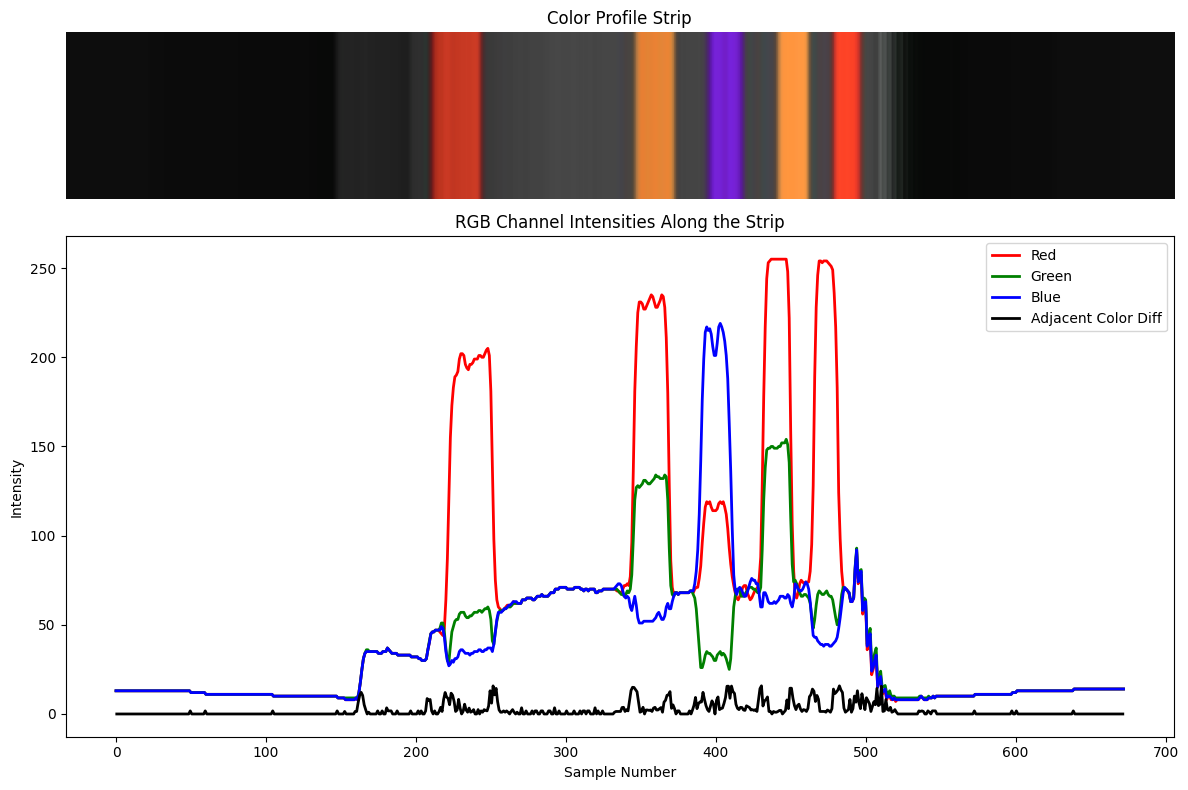

In [78]:
samples = get_points(cv2.imread('images/0001.jpg'))
print(segment_color_strip(samples))
plot_color_strip(samples)

In [5]:
import itertools
import numpy as np
from collections import defaultdict
from sklearn.neighbors import KNeighborsClassifier

# 1) Original samples
raw_samples = {
    (246, 74, 46): 'red',
    (226, 58, 32): 'red',
    (255, 84, 49): 'red',
    (190, 49, 29): 'red',
    (235, 72, 44): 'red',

    (240, 135, 48): 'orange',
    (255, 150, 62): 'orange',
    (216, 127, 52): 'orange',

    ( 172, 96, 33 ): 'brown',
    (151, 85, 30): 'brown',
    (161, 101, 40): 'brown',
    (141,77,21): 'brown',
    (101, 55, 10): 'brown',

    ( 63, 247, 47): 'green',
    (48, 255, 33): 'green',
    (70, 238, 49): 'green',

    (172, 170, 49): 'yellow',
    (190, 189, 55): 'yellow',
    (152, 153, 35): 'yellow',
    (186, 186, 0): 'yellow',

    (172, 146, 43): 'gold',
    (158, 134, 37): 'gold',
    (192, 166, 44): 'gold',

    (147, 147, 147): 'silver',
    (172, 172, 172): 'silver',

    ( 42, 42, 42): 'stick',
    ( 50, 50, 50): 'stick',
    (85, 85, 85): 'stick',

    (94, 94, 94): 'gray',
    (101, 101, 101): 'gray',
    (115, 115, 115): 'gray',
    (122, 122, 122): 'gray',
    (127, 127, 127): 'gray',

    (190, 190, 190): 'white',
    (215, 215, 215): 'white',
    (246, 246, 246): 'white',

    (  46, 24, 212 ): 'blue',
    (  42, 24, 250): 'blue',
    (  63, 30, 250 ): 'blue',

    ( 111, 27, 95): 'violet',
    ( 95, 21, 177): 'violet',
    (142, 55, 251): 'violet',
    (139, 48, 238): 'violet',

    (  4, 4, 4 ): 'black',
}

# 2) Group by class
samples_by_class = defaultdict(list)
for rgb, name in raw_samples.items():
    samples_by_class[name].append(np.array(rgb))

# 3) Augment with linear interpolation
augmented = []
for name, samples in samples_by_class.items():
    # add originals
    for rgb in samples:
        augmented.append((rgb, name))
    # interpolate between each pair
    for a, b in itertools.combinations(samples, 2):
        for t in np.linspace(0.2, 0.8, 3):  # at 20%, 50%, 80%
            interp = (a*(1-t) + b*t).round().astype(int)
            augmented.append((interp, name))

# 4) Prepare data
X = np.stack([rgb for rgb,name in augmented])
y = [name for rgb,name in augmented]

# 5) Train k-NN
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X, y)

# 6) Conversion function
def rgb_to_band(rgb_tuple):
    return knn.predict([rgb_tuple])[0]


In [6]:
def filter_and_aggregate(names, min_run=5):
    # Step 1: First pass—run‐length encode the raw names
    runs = []  # list of (color, start_idx, end_idx)
    prev = names[0]
    start = 0
    for i, name in enumerate(names[1:], start=1):
        if name != prev:
            runs.append((prev, start, i-1))
            prev = name
            start = i
    runs.append((prev, start, len(names)-1))

    # Step 2: Filter out runs shorter than min_run
    filtered = []
    for color, s, e in runs:
        length = e - s + 1
        if length >= min_run:
            filtered.append((color, s, e))
        # else: drop it

    # Step 3: Merge adjacent runs of the *same* color that survived filtering
    merged = []
    for color, s, e in filtered:
        if merged and merged[-1][0] == color:
            # extend the previous run
            prev_color, prev_s, prev_e = merged[-1]
            merged[-1] = (color, prev_s, e)
        else:
            merged.append((color, s, e))

    # Step 4: Build the final (color, count) list
    b = [(color, e - s + 1) for color, s, e in merged]
    if len(b) >= 2 and b[0][0] == 'black':
        b = b[2:]
    if len(b) >= 2 and b[-1][0] == 'black':
        b = b[:-2]
    return [c for c in b]

def select_bands(bands, target_size=5):
    """
    bands: list of (color, count) tuples
    returns: up to target_size tuples from bands that have 'stick' neighbors
    """
    n = len(bands)
    both, one = [], []

    for i, tup in enumerate(bands):
        name, _ = tup
        left  = bands[i-1][0] if i>0   else None
        right = bands[i+1][0] if i<n-1 else None
        sticks = (left in ('stick',)) + (right in ('stick',))

        if sticks == 2:
            both.append((i, tup))
        elif sticks == 1:
            # for one‑stick, we also note if the other neighbor is gray/silver
            other = left if right in ('stick',) else right
            one.append((i, tup, other in ('gray','silver')))

    # sort both and one by original index
    both.sort(key=lambda x: x[0])
    one.sort(key=lambda x: x[0])

    result = []
    # 1) take all both‑sides first
    for idx, tup in both:
        if len(result) < target_size:
            result.append((idx, tup))

    # 2) if still short, take one‑side with other ≠ gray/silver first
    if len(result) < target_size:
        for idx, tup, other_is_gray in one:
            if not other_is_gray and len(result) < target_size:
                result.append((idx, tup))

    # 3) if still short, take the remaining one‑side (even if other is gray/silver)
    if len(result) < target_size:
        for idx, tup, _ in one:
            if len(result) < target_size and all(idx!=ridx for ridx,_ in result):
                result.append((idx, tup))

    # finally, sort result by original index and return only the tuples
    return [tup for idx,tup in sorted(result, key=lambda x: x[0])]

def merge_pairs(bands):
    merge_groups = [
        ({'orange','brown'}, lambda c1,v1,c2,v2: (c1,v1) if v1>v2 else (c2,v2)),
        ({'silver','gray'},  lambda c1,v1,c2,v2: (c1,v1) if v1>v2 else (c2,v2)),
    ]

    merged = []
    i = 0
    n = len(bands)
    while i < n:
        c1, v1 = bands[i]
        if i+1 < n:
            c2, v2 = bands[i+1]
            for group, chooser in merge_groups:
                if {c1, c2} == group:
                    # pick which color wins based on individual value
                    winner_color, winner_val = chooser(c1,v1,c2,v2)
                    merged.append((winner_color, v1 + v2))
                    i += 2
                    break
            else:
                # no merge-group matched
                merged.append((c1, v1))
                i += 1
        else:
            # last element
            merged.append((c1, v1))
            i += 1

    return merged

def guess_resistor_bands(detections, min_bands=3, max_bands=5):
    """
    Given a list of detections [(color, count), ...] (in left-to-right order)
    this function returns the most-probable resistor bands as a list of tuples.
    
    The approach:
      1. Remove "stick" entries.
      2. For the remaining detections, assign a reliability:
           - Vibrant colors (red, green, brown, orange, violet, yellow, blue, gold, black)
             are given full weight (1.0).
           - Neutrals (silver, gray) get a lower weight (0.3).
      3. Mark as background any neutral candidate that is very large and lies at an extreme
         (for example, if it is the first or last element and its count is above a threshold).
      4. Now partition candidates into vibrant and neutral.
         Use these simple rules:
           - If there are exactly 3 vibrant candidates, we assume the resistor is a 4-band
             device and choose the best (highest-scoring) neutral candidate (if available).
           - If there are 4 or 5 vibrant candidates, we assume that is correct.
           - Otherwise (if we have many candidates) we choose the top max_bands candidates (by score)
             among all non-background ones, then sort them in left-to-right order.
    Returns a list of tuples (color, count) in the original left-to-right order.
    """
    # Define which colors are considered "vibrant" (i.e. nearly always true bands)
    vibrant_colors = set(['red', 'green', 'brown', 'orange', 'violet', 'yellow', 'blue', 'gold', 'black'])
    neutral_colors = set(['silver', 'gray'])
    
    # Reliability weights (tweak as needed)
    weights = { 
        # vibrant colors get full weight
        'red': 1.0, 'green': 1.0, 'brown': 1.0, 'orange': 1.0,
        'violet': 1.0, 'yellow': 1.0, 'blue': 1.0, 'gold': 1.0, 'black': 1.0,
        # neutrals get lower weight
        'silver': 0.3, 'gray': 0.3
    }
    
    # Threshold for considering a candidate as "background" (body of the resistor)
    BACKGROUND_THRESHOLD = 100  # e.g. if count > 100 and it is neutral at the edge
    
    # Collect candidates along with original index.
    candidates = []
    for idx, (color, count) in enumerate(detections):
        c_lower = color.lower()
        # Skip "stick" entries entirely
        if c_lower == 'stick':
            continue
        # Compute score = count * reliability
        weight = weights.get(c_lower, 1.0)
        score = count * weight
        # Mark candidate as background if it is a neutral color with a very high count at an edge.
        background = False
        if c_lower in neutral_colors and count > BACKGROUND_THRESHOLD and (idx == 0 or idx == len(detections)-1):
            background = True
        
        candidates.append({
            'index': idx,
            'color': color,
            'count': count,
            'score': score,
            'vibrant': (c_lower in vibrant_colors),
            'background': background
        })
    
    # If no candidates found, return empty list.
    if not candidates:
        return []
    
    # Partition into vibrant and neutral (ignoring background ones)
    vibrant_cands = [c for c in candidates if c['vibrant'] and not c['background']]
    neutral_cands = [c for c in candidates if (not c['vibrant']) and not c['background']]
    
    selected = []
    # Case 1: Exactly three vibrant bands -> assume a 4-band resistor;
    # add the best neutral candidate (if any) to join them.
    if len(vibrant_cands) == 3:
        selected.extend(vibrant_cands)
        if neutral_cands:
            best_neutral = max(neutral_cands, key=lambda c: c['score'])
            selected.append(best_neutral)
    # Case 2: 4 or 5 vibrant bands -> use them as the answer.
    elif len(vibrant_cands) in [4, 5]:
        selected.extend(vibrant_cands)
    else:
        # Otherwise, combine all non-background candidates
        all_cands = [c for c in candidates if not c['background']]
        # If there are more than max_bands, choose top ones by score.
        if len(all_cands) > max_bands:
            selected = sorted(all_cands, key=lambda c: c['score'], reverse=True)[:max_bands]
        else:
            selected = all_cands
    
    # Finally, sort the selected candidates by their original order (index)
    selected_sorted = sorted(selected, key=lambda c: c['index'])
    # Return the (color, count) tuples.
    return [(c['color'], c['count']) for c in selected_sorted]

In [7]:
mapp = {
    "black": 0,
    "brown": 1,
    "red": 2,
    "orange": 3,
    "yellow": 4,
    "green": 5,
    "blue": 6,
    "violet": 7,
    "gray": 8,
    "white": 9,
    "gold": -1,
    "silver": -2,
}

In [8]:
def solve(img):
    colors = get_points(img)

    names = knn.predict(np.array(colors))
    names = filter_and_aggregate(names)
    names = merge_pairs(names)
    names = merge_pairs(names)

    names = [
        (name, max(
            names[i - 1][1] if i > 0 else 0,
            names[i + 1][1] if i < len(names) - 1 else 0
        )) for i, (name, c) in enumerate(names)
    ]
    names = guess_resistor_bands(names)
    
    mx = 0
    for _, v in names:
        mx = max(mx, v)
    if names[0][1] == mx:
        names = names[::-1]
        
    bands = list(map(lambda x: mapp[x[0]], names))
    while len(bands) < 5: bands.append('-')
    return bands

In [20]:
solve(cv2.imread('images/0004.jpg'))

[4, 1, -1, 8, '-']

In [10]:
import os
from tqdm import tqdm

rows = []
for fname in tqdm(sorted(os.listdir('images'))):
    img = cv2.imread(os.path.join('images', fname))
    try:
        bands = solve(img)
        rows.append({
            'id': os.path.splitext(fname)[0],
            'type': 'axial',
            'a': bands[0],
            'b': bands[1],
            'c': bands[2],
            'd': bands[3],
            'e': bands[4],
        })
    except:
        rows.append({
            'id': os.path.splitext(fname)[0],
            'type': 'smd',
            'a': '-',
            'b': '-',
            'c': '-',
            'd': '-',
            'e': '-',
        })

  2%|▏         | 88/4096 [00:03<02:54, 22.99it/s]


KeyboardInterrupt: 

In [9]:
import pandas as pd 
df = pd.DataFrame(rows, columns=['id','type','a','b','c','d','e'])
df.to_csv('sub.csv', index=False)
df.head(5)

,id,type,a,b,c,d,e
0,0000,axial,1,2,0,4,-
1,0001,axial,2,3,7,3,2
2,0002,smd,-,-,-,-,-
3,0003,axial,5,1,0,3,2
4,0004,axial,4,1,-1,8,-
5,0005,axial,7,5,0,1,2
6,0006,axial,1,9,4,2,-
7,0007,axial,8,6,9,6,8
8,0008,axial,6,6,6,6,6
9,0009,axial,8,8,-,-,-


In [2]:
import easyocr
reader = easyocr.Reader(
    ['en'],
    gpu=False,
)

Using CPU. Note: This module is much faster with a GPU.


In [66]:
def autorotate(img):
    th = img
    th = cv2.threshold(th, 10, 255, cv2.THRESH_BINARY)[1]
    cv2.imwrite('04.png', th)
    
    h, w = th.shape
    
    xs, ys = [], []
    for x in range(w):
        col = th[:, x]
        whites = np.where(col == 255)[0]
        if whites.size:
            ys.append(whites.min())   # first white row
            xs.append(x)              # this column
    
    xs = np.array(xs, dtype=np.float32)
    ys = np.array(ys, dtype=np.float32)

    A = np.vstack([xs, np.ones_like(xs)]).T
    (m, b), residuals, rank, s = np.linalg.lstsq(A, ys, rcond=None)
    
    angle = m * 180 / np.pi
    
    M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), angle, scale=1.0)
    return cv2.warpAffine(
        img, M, (img.shape[1], img.shape[0]),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0)  # black padding
    )

def auto_crop_border(mask, max_iters=10, step=5):
    h, w = mask.shape
    mask[ mask < 20 ] = 0
    top, left, bottom, right = 0, 0, h, w
    
    for i in range(max_iters):
        # crop the outer border strip of width `step`
        top_strip    = mask[top: top+step, left:right]
        bottom_strip = mask[bottom-step: bottom, left:right]
        left_strip   = mask[top:bottom, left: left+step]
        right_strip  = mask[top:bottom, right-step: right]
        
        if (top_strip.sum() or bottom_strip.sum() or
            left_strip.sum() or right_strip.sum()):
            break
        
        # otherwise, shrink the crop window inward
        top    += step
        left   += step
        bottom -= step
        right  -= step
        
        # guard against over‑cropping
        if bottom - top <= step*2 or right - left <= step*2:
            break
    
    return mask[top:bottom, left:right]

def ocr(img):
    img = autorotate(img)
    # img = cv2.flip(img, -1)
    img = auto_crop_border(img, 5, 20)
    cv2.imwrite('04.png', img)
    def run(oimg):
        results = reader.readtext(
            image=oimg,
            detail=1,            # return (bbox, text, conf)
            paragraph=False,
            decoder='greedy',
            allowlist='0123456789R',
            batch_size=1,
        )
        if not results:
            return '', 0.0
        _, text, conf = max(results, key=lambda x: x[2])
        return text, conf
    
    text1, conf1 = run(img)
    flipped = cv2.flip(img, -1)
    text2, conf2 = run(flipped)
    
    return text2 if conf2 > conf1 else text1

In [64]:
img = cv2.imread('images/0000.jpg', cv2.IMREAD_GRAYSCALE)
ocr(img)

''

In [69]:
import os
import re 
from tqdm import tqdm

SMD_PATTERN = re.compile(r'^(\d{3,4}|[0-9]R[0-9])$')

rows = []
for fname in tqdm(sorted(os.listdir('images'))):
    img = cv2.imread(os.path.join('images', fname), cv2.IMREAD_GRAYSCALE)
    result = ocr(img)
    if SMD_PATTERN.match(result):
        rows.append({
            'id': os.path.splitext(fname)[0],
            'type': 'smd',
            'a': result,
            'b': '-',
            'c': '-',
            'd': '-',
            'e': '-',
        })
    else:
        try:
            bands = solve(img)
            rows.append({
                'id': os.path.splitext(fname)[0],
                'type': 'axial',
                'a': bands[0],
                'b': bands[1],
                'c': bands[2],
                'd': bands[3],
                'e': bands[4],
            })
        except:
            rows.append({
                'id': os.path.splitext(fname)[0],
                'type': 'smd',
                'a': '-',
                'b': '-',
                'c': '-',
                'd': '-',
                'e': '-',
            })

  0%|          | 3/4096 [00:04<1:38:02,  1.44s/it]


KeyboardInterrupt: 

In [14]:
import pandas as pd

# Load both CSVs
smd = pd.read_csv('smd.csv')
sub = pd.read_csv('sub.csv')

# Boolean mask of rows to overwrite
mask = smd['a'] != '-'

# Overwrite in-place in `sub` for those rows
sub.loc[mask, :] = smd.loc[mask, :]

# Save back
sub.to_csv('sub_real.csv', index=False)


In [13]:
import pandas as pd

# Load both CSVs
smd = pd.read_csv('smddd.csv')
sub = pd.read_csv('sub_real.csv')

# Boolean mask of rows to overwrite
mask = (smd['a'] != '-') & (sub['c'] == '-')

# Overwrite in-place in `sub` for those rows
sub.loc[mask, :] = smd.loc[mask, :]

# Save back
sub.to_csv('sub_sus.csv', index=False)
